# Cross-Language Rap Detector

## Cross-validation on the Training Set

In [80]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

import numpy as np
import pandas as pd
import pickle
import scipy.sparse
from sklearn import cross_validation
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [3]:
def feature_distribution(data, which_feature):
    med = np.median(train_data.loc[:,which_feature])
    q75, q25 = np.percentile(train_data.loc[:,which_feature], [75 ,25])
    iqr = q75 - q25
    minx = med-(iqr*2.5)
    if minx < 0:
        minx = 0
    maxx = med+(iqr*2.5)
    nbins = 20
    bins = np.linspace(minx, maxx, nbins+1) 

    plt.figure()
    sns.distplot(data.loc[data.rap==0,which_feature], bins=bins, label='Non-rap')
    sns.distplot(data.loc[data.rap==1,which_feature], bins=bins, label='Rap')
    plt.xlim(minx, maxx)
    plt.title(which_feature)
    plt.legend()
    
def examine_prediction(y, prediction, data, features, show_misidentified=True):
    cm = confusion_matrix(y, prediction)
    np.set_printoptions(precision=2)  
    print "Accuracy =\t%.3f" % metrics.accuracy_score(y, prediction)
    print "F1 score =\t%.3f" % metrics.f1_score(y, prediction)
    print('Confusion matrix, without normalization')
    print(cm)
    print "Precision =\t%.3f" % metrics.precision_score(y, prediction)
    print "Recall =\t%.3f" % metrics.recall_score(y, prediction)
    if show_misidentified:
        print "Misidentified as rap: "
        print data.loc[(prediction==1) & (y==0),['names','track_name']+features]
        print "Misidentified as nonrap: "
        print data.loc[(prediction==0) & (y==1),['names','track_name']+features]

def compute_features(lyrics, tdm_indices):
    total_num_words = np.zeros(len(tdm_indices))
    for i in range(len(tdm_indices)):
        total_num_words[i] =  lyrics['tdm'][tdm_indices[i],:].sum()
	
    word_lens = np.array([len(i) for i in lyrics['unstemmed_terms']],dtype=float)
    mean_word_length = np.zeros(len(tdm_indices))
    for i in range(len(tdm_indices)):
        word_indices = lyrics['tdm'][tdm_indices[i],:].nonzero()[1]
        mean_word_length[i] = np.mean(word_lens[word_indices])

    median_word_rank = np.zeros(len(tdm_indices))
    for i in range(len(tdm_indices)):
        word_indices = lyrics['tdm'][tdm_indices[i],:].nonzero()[1]
        median_word_rank[i] = np.median(word_indices)
    
    mean_word_instances = np.zeros(len(tdm_indices))
    for i in range(len(tdm_indices)):
        nums = lyrics['tdm'][tdm_indices[i],:].toarray()
        nz = nums[nums.nonzero()]
        mean_word_instances[i] = np.mean(nz)
    mean_word_instances = np.divide(mean_word_instances, total_num_words)
    
    additional_features = pd.DataFrame(data={'total_num_words':total_num_words, 'mean_word_length':mean_word_length, 'median_word_rank':median_word_rank, 'mean_word_instances':mean_word_instances})
    return additional_features

In [4]:
with open('train_track_info.pickle','r') as f:
	track_info = pickle.load(f)
    
with open('train_lyrics_data.pickle','r') as f:
	lyrics = pickle.load(f)

In [5]:
# Reduce the number of non-rap training samples so that it is balanced with the rap training samples
y = track_info.loc[:,'rap']
num_rap_tracks = np.sum(y)
all_rap_artists = np.unique(track_info.loc[track_info.rap==1,'spotify_artist_id'])
all_nonrap_artists = np.unique(track_info.loc[track_info.rap==0,'spotify_artist_id'])


# Match the number of artists between the nonrap sample and the rap sample (otherwise the nonrap might have more variety of artists)
rs = cross_validation.ShuffleSplit(len(all_nonrap_artists), n_iter=1, test_size=len(all_rap_artists),random_state=7)
sampled_nonrap_artists =  next(iter(rs))[1]
non_rap_tracks = track_info.merge(right=pd.DataFrame(data={'spotify_artist_id':all_nonrap_artists[sampled_nonrap_artists]}),on='spotify_artist_id',how='inner')

# Since nonrap artists tended to have more songs in the set than rap artists, 
# still have to randomly sample tracks from across the non-rap tracks to match the number of
# rap and non-rap tracks
g=  track_info.groupby(by=['rap','spotify_artist_id']) 
num_songs_per_artist = g.count()['mxm_tid']
rap_songs_per_artist = np.mean(num_songs_per_artist[1])
non_rap_songs_per_artist = np.mean(num_songs_per_artist[0])
print "Mean number of songs per rap artist: %.2f" % rap_songs_per_artist
print "Mean number of songs per non-rap artist: %.2f" %  non_rap_songs_per_artist

rs = cross_validation.ShuffleSplit(len(non_rap_tracks), n_iter=1, test_size=num_rap_tracks,random_state=7)
sampled_nonrap_tracks =  next(iter(rs))[1]
non_rap_tracks = non_rap_tracks.loc[sampled_nonrap_tracks,:]
train_data = pd.concat([non_rap_tracks,track_info.loc[track_info.rap==1,:]],ignore_index=True)

y = train_data.loc[:,'rap']

Mean number of songs per rap artist: 5.90
Mean number of songs per non-rap artist: 7.98


In [6]:
new_features = compute_features(lyrics, train_data.tdm_row)
train_data = pd.concat([train_data, new_features],axis=1)


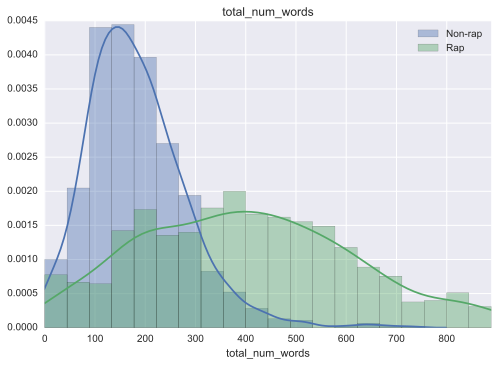

In [7]:
# Create features
feature_distribution(train_data,'total_num_words')

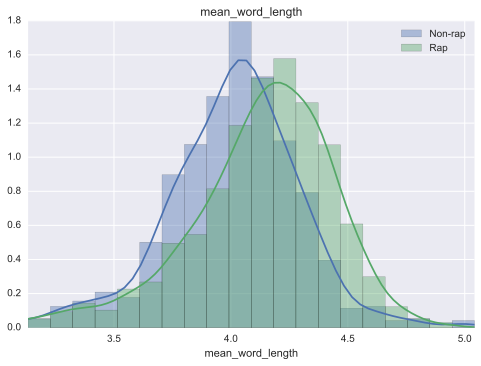

In [8]:

feature_distribution(train_data,'mean_word_length')

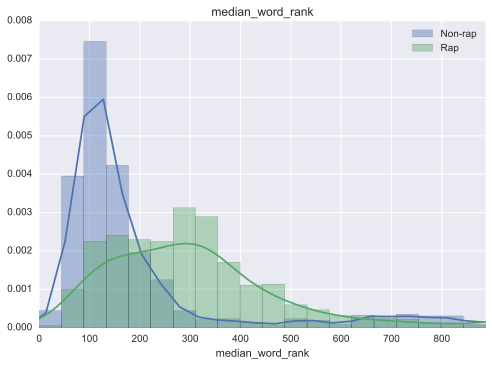

In [9]:
feature_distribution(train_data,'median_word_rank')

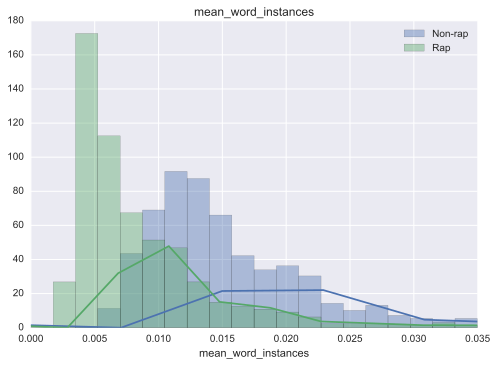

In [10]:

feature_distribution(train_data,'mean_word_instances')

In [11]:
#sfeatures = ['total_num_words','mean_word_length','rap']
#a  = sns.pairplot(train_data.loc[:,sfeatures], hue='rap', diag_kind="kde", kind="reg")
#sfeatures = ['median_word_rank','mean_word_instances','rap']
#a  = sns.pairplot(train_data.loc[:,sfeatures], hue='rap', diag_kind="kde", kind="reg")

In [12]:
features = ['total_num_words','mean_word_length','median_word_rank','mean_word_instances']
g = train_data.groupby('rap')
print g.median()[features]
print g.sem()[features]

     total_num_words  mean_word_length  median_word_rank  mean_word_instances
rap                                                                          
0              169.0          4.020202             135.0             0.014085
1              395.0          4.166667             310.0             0.006623
     total_num_words  mean_word_length  median_word_rank  mean_word_instances
rap                                                                          
0           3.072018          0.010807         11.644508             0.001456
1           6.844774          0.010696         11.871767             0.000838


In [13]:
# Fit random forest to all the data and validate on the same data (not a good idea)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_data.loc[:,features], y)
prediction = clf.predict(train_data.loc[:,features])
prop_corr = np.mean(prediction == y)
print prop_corr

1.0


In [14]:
# Prepare for cross validation fittings
num_folds=10
num_instances = len(train_data)
scoring = 'accuracy'
seed = 7
kfold = cross_validation.KFold(n=num_instances, shuffle=True, n_folds=num_folds, random_state=seed)

In [15]:
# Cross validate Random forest 
clf = RandomForestClassifier(n_estimators=100)
results = cross_validation.cross_val_score(clf,train_data.loc[:,features], y, cv=kfold, scoring=scoring)
print np.mean(results)

0.816113221706


In [18]:
scaler = preprocessing.StandardScaler().fit(train_data.loc[:,features])
train_data_scaled = scaler.transform(train_data.loc[:,features])

splt = cross_validation.StratifiedShuffleSplit(y, test_size=0.1,n_iter=1, random_state=7)
splt = next(iter(splt))
clf = RandomForestClassifier(n_estimators=100)
fitinfo = clf.fit(train_data_scaled[splt[0],:], y[splt[0]])
prediction = clf.predict(train_data_scaled[splt[1],:])
examine_prediction(y[splt[1]], prediction, train_data.loc[splt[1],:], features)

Accuracy =	0.806
F1 score =	0.789
Confusion matrix, without normalization
[[91 12]
 [28 75]]
Precision =	0.862
Recall =	0.728
Misidentified as rap: 
                    names                            track_name  \
583          Matthew Good                  Champions Of Nothing   
83    The O.C. Supertones                    Escape From Reason   
803                  Stoa                                 Alone   
137        As I Lay Dying                    Meaning in Tragedy   
47       Charlotte Church  Moodswings (To Come At Me Like That)   
175       Hot Water Music                          A Clear Line   
841             Sugarland                        A Thick Forest   
1015      Newton Faulkner                       Lipstick Jungle   
631                 Kisha                              Survivor   
211     Before Their Eyes                            So In Love   
72             Tiger Army     Prelude: Call Of The Ghost Tigers   
904             Jovanotti                      

In [19]:
# Cross validate Logistic regression
clf = LogisticRegression()
kfold = cross_validation.KFold(n=num_instances, shuffle=True, n_folds=num_folds, random_state=seed)
results = cross_validation.cross_val_score(clf,train_data_scaled, train_data.loc[:,'rap'], cv=kfold, scoring=scoring)
print np.mean(results)

0.798693776089


In [20]:
# Check a fit
splt = cross_validation.StratifiedShuffleSplit(y, test_size=0.1,n_iter=1, random_state=7)
splt = next(iter(splt))
clf = LogisticRegression()
kfitinfo = clf.fit(train_data_scaled[splt[0],:], y[splt[0]])
prediction = clf.predict(train_data_scaled[splt[1],:])
examine_prediction(y[splt[1]], prediction, train_data.loc[splt[1],:], features)

Accuracy =	0.796
F1 score =	0.777
Confusion matrix, without normalization
[[91 12]
 [30 73]]
Precision =	0.859
Recall =	0.709
Misidentified as rap: 
                    names                            track_name  \
583          Matthew Good                  Champions Of Nothing   
83    The O.C. Supertones                    Escape From Reason   
823                   SWV                           Surprise Me   
803                  Stoa                                 Alone   
47       Charlotte Church  Moodswings (To Come At Me Like That)   
841             Sugarland                        A Thick Forest   
1015      Newton Faulkner                       Lipstick Jungle   
631                 Kisha                              Survivor   
462                 Kisha                        Nobody Like Me   
211     Before Their Eyes                            So In Love   
763           Billy Bragg            Sing Their Souls Back Home   
904             Jovanotti                      

In [21]:
# Cross validate  SVM

scaler = preprocessing.StandardScaler().fit(train_data.loc[:,features])
train_data_scaled = scaler.transform(train_data.loc[:,features])

clf = svm.SVC()
results = cross_validation.cross_val_score(clf,train_data_scaled, y, cv=kfold, scoring=scoring)
print "Cross-validation mean accuracy = %.3f" % np.mean(results)

Cross-validation mean accuracy = 0.810


In [22]:
# Check a fit 
splt = cross_validation.StratifiedShuffleSplit(y, test_size=0.1,n_iter=1, random_state=7)
splt = next(iter(splt))
fitinfo = clf.fit(train_data_scaled[splt[0],:], y[splt[0]])
prediction = clf.predict(train_data_scaled[splt[1],:])

examine_prediction(y[splt[1]], prediction, train_data.loc[splt[1],:], features)

Accuracy =	0.796
F1 score =	0.764
Confusion matrix, without normalization
[[96  7]
 [35 68]]
Precision =	0.907
Recall =	0.660
Misidentified as rap: 
                   names            track_name  total_num_words  \
583         Matthew Good  Champions Of Nothing            400.0   
83   The O.C. Supertones    Escape From Reason            354.0   
803                 Stoa                 Alone            430.0   
841            Sugarland        A Thick Forest            320.0   
631                Kisha              Survivor            647.0   
462                Kisha        Nobody Like Me            422.0   
904            Jovanotti             Si Va Via            521.0   

     mean_word_length  median_word_rank  mean_word_instances  
583          4.279412             188.0             0.007353  
83           4.455128             222.5             0.006410  
803          4.009174             135.0             0.009174  
841          4.371212             201.0             0.007576  

Optimal number of features : 3


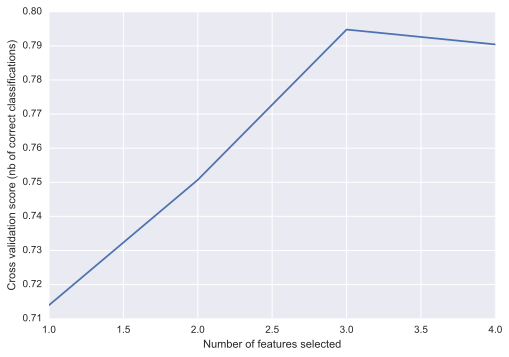

1 mean_word_instances	Importance = 0.32
2 total_num_words	Importance = 0.31
3 median_word_rank	Importance = 0.23
4 mean_word_length	Importance = 0.14


In [23]:
# Recursive number of features selection

#clf = svm.SVC(kernel='linear')
clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_data_scaled, y)
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(y, 2, random_state=7), scoring='accuracy')
rfecv.fit(train_data_scaled, y)

print("Optimal number of features : %d" % rfecv.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

order = np.argsort(clf.feature_importances_)[::-1]
for i,o in enumerate(order):
	print "%d %s\tImportance = %.2f" % (i+1, features[o], clf.feature_importances_[o])

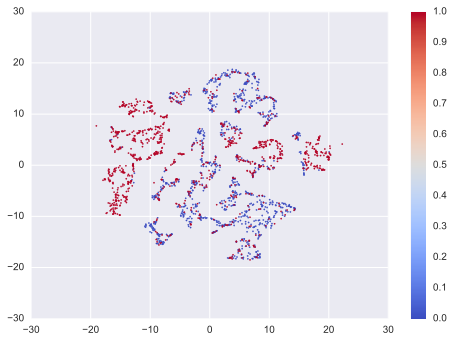

In [24]:
# TSNE embedding of the points onto a 2 plane

tsne = TSNE()
proj = tsne.fit_transform(train_data.loc[:,features])

plt.figure() 
plt.set_cmap("coolwarm")
plt.scatter(proj[:, 0], proj[:, 1],s=2, c=y, alpha=1, edgecolors='face')
plt.colorbar()


## Test set results

In [25]:
with open('test_track_info.pickle','r') as f:
	test_track_info = pickle.load(f)
    
with open('test_lyrics_data.pickle','r') as f:
	test_lyrics = pickle.load(f)

In [26]:
pd.value_counts(test_track_info.rap)

0    3238
1      84
Name: rap, dtype: int64

In [28]:
new_features = compute_features(test_lyrics, test_track_info.tdm_row)
test_data = pd.concat([test_track_info, new_features],axis=1)
test_data_scaled = scaler.transform(test_data.loc[:,features])  # Use scaler that was fit on train_data

In [30]:
# Baseline measure: none are rap
prediction = np.zeros(len(test_data))

examine_prediction(test_data.rap, prediction, test_data, features, show_misidentified=False)

Accuracy =	0.975
F1 score =	0.000
Confusion matrix, without normalization
[[3238    0]
 [  84    0]]
Precision =	0.000
Recall =	0.000


In [31]:
# Train SVM on the whole training set
clf = svm.SVC()
fitinfo = clf.fit(train_data_scaled, y)
prediction = clf.predict(test_data_scaled)

examine_prediction(test_data.rap, prediction, test_data, features, show_misidentified=False)

Accuracy =	0.930
F1 score =	0.368
Confusion matrix, without normalization
[[3020  218]
 [  16   68]]
Precision =	0.238
Recall =	0.810


In [32]:
# Just for interest, a random forest
clf = RandomForestClassifier(n_estimators=100)
fitinfo = clf.fit(train_data_scaled, y)
prediction = clf.predict(test_data_scaled)

examine_prediction(test_data.rap, prediction, test_data, features, show_misidentified=False)

Accuracy =	0.865
F1 score =	0.237
Confusion matrix, without normalization
[[2802  436]
 [  14   70]]
Precision =	0.138
Recall =	0.833


## Attempt 2: Training on unbalanced data with SVM class weights

In [33]:
un_train_data = track_info.copy()
new_features = compute_features(lyrics, un_train_data.tdm_row)
un_train_data = pd.concat([un_train_data, new_features],axis=1) 

In [34]:
pd.value_counts(un_train_data.rap)

0    26100
1     1033
Name: rap, dtype: int64

In [35]:
# Baseline measure: none are rap
prediction = np.zeros(len(un_train_data))

examine_prediction(un_train_data.rap, prediction, un_train_data, features, show_misidentified=False)

Accuracy =	0.962
F1 score =	0.000
Confusion matrix, without normalization
[[26100     0]
 [ 1033     0]]
Precision =	0.000
Recall =	0.000


In [36]:
# Cross-validation of SVM on unbalanced data
scaler_un = preprocessing.StandardScaler().fit(un_train_data.loc[:,features])
un_train_data_scaled = scaler_un.transform(un_train_data.loc[:,features])
un_y = un_train_data.rap

clf = svm.SVC()
results = cross_validation.cross_val_score(clf,un_train_data_scaled, un_y, cv=kfold, scoring=scoring)
print "Cross-validation mean accuracy = %.3f" % np.mean(results)
results = cross_validation.cross_val_score(clf,un_train_data_scaled, un_y, cv=kfold, scoring='f1_weighted')
print "Cross-validation mean f1 weighted = %.3f" % np.mean(results)

Cross-validation mean accuracy = 0.985


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross-validation mean f1 weighted = 0.979


In [37]:
# Cross-validation of SVM on unbalanced data with class weightings
clf = svm.SVC(class_weight='balanced')
results = cross_validation.cross_val_score(clf,un_train_data_scaled, un_y, cv=kfold, scoring=scoring)
print "Cross-validation mean accuracy = %.3f" % np.mean(results)
results = cross_validation.cross_val_score(clf,un_train_data_scaled, un_y, cv=kfold, scoring='f1_weighted')
print "Cross-validation mean f1 weighted = %.3f" % np.mean(results)

Cross-validation mean accuracy = 0.954
Cross-validation mean f1 weighted = 0.966


In [38]:
# SVM on unbalanced training data applied to test data
clf = svm.SVC(class_weight=None)
fitinfo = clf.fit(un_train_data_scaled, un_y)
test_data_scaled_un = scaler_un.transform(test_data.loc[:,features]) # Different scaler
prediction = clf.predict(test_data_scaled_un)

examine_prediction(test_data.rap, prediction, test_data, features, show_misidentified=False)

Accuracy =	0.978
F1 score =	0.422
Confusion matrix, without normalization
[[3221   17]
 [  57   27]]
Precision =	0.614
Recall =	0.321


In [39]:
# SVM with class weighting on unbalanced training data applied to test data

clf = svm.SVC(class_weight='balanced')
fitinfo = clf.fit(un_train_data_scaled, un_y)
prediction = clf.predict(test_data_scaled_un)

examine_prediction(test_data.rap, prediction, test_data, features, show_misidentified=True)

Accuracy =	0.946
F1 score =	0.434
Confusion matrix, without normalization
[[3073  165]
 [  15   69]]
Precision =	0.295
Recall =	0.821
Misidentified as rap: 
                           names  \
14    The String Cheese Incident   
24    The String Cheese Incident   
41    The String Cheese Incident   
56                 Manolo Garcia   
120                          ASP   
121                          ASP   
122                          ASP   
126                          ASP   
127                          ASP   
128              Raheem DeVaughn   
129              Raheem DeVaughn   
130              Raheem DeVaughn   
131              Raheem DeVaughn   
133              Raheem DeVaughn   
277                Mercyful Fate   
298                  Electrocute   
319            Luis Eduardo Aute   
349                Pet Shop Boys   
355                Pet Shop Boys   
358                Pet Shop Boys   
364                Pet Shop Boys   
368                Pet Shop Boys   
434            

In [40]:
cw = len(un_y)/(2. * np.bincount(un_y))
clf = svm.SVC(class_weight={0:cw[0],1:cw[1]})
fitinfo = clf.fit(un_train_data_scaled, un_y)
prediction = clf.predict(test_data_scaled_un)

examine_prediction(test_data.rap, prediction, test_data, features, show_misidentified=False)

Accuracy =	0.946
F1 score =	0.434
Confusion matrix, without normalization
[[3073  165]
 [  15   69]]
Precision =	0.295
Recall =	0.821


In [41]:
cw

array([  0.52,  13.13])

In [ ]:
#from sklearn import grid_search

ratios = np.linspace(float(np.sum(un_y))/len(un_y),0.5,10)
#cws = [{0:len(un_y)/(2 * len(un_y)*(1-r)),1:len(un_y)/(2 * len(un_y)*r)} for r in ratios]
#param_grid = {'class_weight':cws}
#clf = svm.SVC()
#clf.fit(un_train_data_scaled, un_y)
#gs = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='f1')
#gs.fit(un_train_data_scaled, un_y)
#for params, mean_score, scores in gs.grid_scores_:
#       print("%0.3f (+/-%0.03f) for %r"
#            % (mean_score, scores.std() * 2, params))

```0.388 (+/-0.007) for {'class_weight': {0: 0.51978927203065139, 1: 13.133107454017425}}
0.502 (+/-0.068) for {'class_weight': {0: 0.54908675542404095, 1: 5.5930235221364608}}
0.532 (+/-0.121) for {'class_weight': {0: 0.58188416502647344, 1: 3.5530933535094866}}
0.533 (+/-0.127) for {'class_weight': {0: 0.61884850189686236, 1: 2.6035183112106193}}
0.532 (+/-0.144) for {'class_weight': {0: 0.66082774969420788, 1: 2.0544581110868068}}
0.528 (+/-0.158) for {'class_weight': {0: 0.70891672593732302, 1: 1.6966490422361025}}
0.511 (+/-0.146) for {'class_weight': {0: 0.76455394210358241, 1: 1.4449868635944048}}
0.483 (+/-0.149) for {'class_weight': {0: 0.829667958862641, 1: 1.2583387868887939}}
0.452 (+/-0.128) for {'class_weight': {0: 0.90690549052231262, 1: 1.1143932825263543}}
0.390 (+/-0.077) for {'class_weight': {0: 1.0, 1: 1.0}}```

In [78]:
clf = svm.SVC(class_weight=cws[4])
fitinfo = clf.fit(un_train_data_scaled, un_y)
prediction = clf.predict(test_data_scaled_un)

examine_prediction(test_data.rap, prediction, test_data, features, show_misidentified=True)

Accuracy =	0.978
F1 score =	0.589
Confusion matrix, without normalization
[[3195   43]
 [  31   53]]
Precision =	0.552
Recall =	0.631
Misidentified as rap: 
                     names                                         track_name  \
120                    ASP                                Verwandlungen I-III   
121                    ASP  Der geheimnisvolle Fremde (Ja, ja, drei Mal Hu...   
368          Pet Shop Boys                     Rent - 2001 Remastered Version   
434            Mad Caddies                                               Riot   
450           Marc Anthony                                           Mi Gente   
451           Marc Anthony                                          Si Te Vas   
457           Marc Anthony                                        El Cantante   
533                MC Lars                        It's Not Easy (Being Green)   
535                MC Lars                             This Giant Robot Kills   
537                MC Lars       